In [20]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
import numpy as np

os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['HIP_VISIBLE_DEVICES'] = '0'

In [2]:
seed = 123
torch.manual_seed(seed)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
train_set = MNIST(root="../datasets", train=True, download=True, transform=transforms.ToTensor())
test_set = MNIST(root="../datasets", train=False, download=True, transform=transforms.ToTensor())

In [4]:
BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=True)

In [5]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=200, z_dim=20) -> None:
        super(VariationalAutoEncoder, self).__init__()

        # encoder
        self.img_2hid = nn.Linear(input_dim, hidden_dim)
        self.hid_2mu = nn.Linear(hidden_dim, z_dim)
        self.hid_2sigma = nn.Linear(hidden_dim, z_dim)

        # decoder
        self.z_2hid = nn.Linear(z_dim, hidden_dim)
        self.hid_2img = nn.Linear(hidden_dim, input_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    # input img -> Hidden dim -> mean, std -> Parametrization trick -> Decoder -> output
    def encode(self, x):
        x = self.relu(self.img_2hid(x))
        mu, sigma = self.hid_2mu(x), torch.exp(0.5 * self.hid_2sigma(x))
        return mu, sigma

    def decode(self, x):
        x = self.relu(self.z_2hid(x))
        x = self.hid_2img(x)
        return self.sigmoid(x)
    
    def forward(self, x):
        mu, sigma = self.encode(x)
        eps = torch.randn_like(sigma)
        z_reparametrizes = mu + sigma * eps
        x_reconstructed = self.decode(z_reparametrizes)

        return x_reconstructed, mu, sigma, z_reparametrizes

In [6]:
model = VariationalAutoEncoder(input_dim=28 * 28, z_dim=32).to(DEVICE)

In [7]:
NUM_EPOCH = 40
LEARNING_RATE = 1e-4

criterion = nn.BCELoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [8]:
min_loss = float('inf')
train_loss = []

for epoch in range(NUM_EPOCH):

    total_loss = 0
    for img, _ in tqdm(train_loader, desc=f'Epoch: {epoch + 1}'):
        
        img = img.view(-1, 1 * 28 * 28).to(DEVICE)
        x_reconstructed, mu, sigma, _ = model(img)

        kl_divergance = - 0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        loss = criterion(x_reconstructed, img) + kl_divergance
        
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = total_loss / BATCH_SIZE
    train_loss.append(epoch_loss)

    print(f'Epoch: {epoch + 1} | Loss: {epoch_loss:.4f}')

    if epoch_loss < min_loss:
        torch.save(model.state_dict(), "./best_model.pth")
        torch.save(optimizer.state_dict(), "./optimizer_states.pth")
        min_loss = epoch_loss

Epoch: 1: 100%|██████████| 938/938 [00:07<00:00, 121.57it/s]


Epoch: 1 | Loss: 232867.1499


Epoch: 2: 100%|██████████| 938/938 [00:06<00:00, 137.93it/s]


Epoch: 2 | Loss: 164815.7521


Epoch: 3: 100%|██████████| 938/938 [00:06<00:00, 138.78it/s]


Epoch: 3 | Loss: 149269.3701


Epoch: 4: 100%|██████████| 938/938 [00:06<00:00, 139.20it/s]


Epoch: 4 | Loss: 140317.9429


Epoch: 5: 100%|██████████| 938/938 [00:06<00:00, 137.85it/s]


Epoch: 5 | Loss: 133450.3981


Epoch: 6: 100%|██████████| 938/938 [00:06<00:00, 135.87it/s]


Epoch: 6 | Loss: 128624.1772


Epoch: 7: 100%|██████████| 938/938 [00:06<00:00, 134.01it/s]


Epoch: 7 | Loss: 125003.4669


Epoch: 8: 100%|██████████| 938/938 [00:06<00:00, 134.17it/s]


Epoch: 8 | Loss: 121952.7878


Epoch: 9: 100%|██████████| 938/938 [00:07<00:00, 131.79it/s]


Epoch: 9 | Loss: 119516.1118


Epoch: 10: 100%|██████████| 938/938 [00:07<00:00, 133.89it/s]


Epoch: 10 | Loss: 117364.9212


Epoch: 11: 100%|██████████| 938/938 [00:06<00:00, 136.17it/s]


Epoch: 11 | Loss: 115584.9140


Epoch: 12: 100%|██████████| 938/938 [00:06<00:00, 134.02it/s]


Epoch: 12 | Loss: 114078.3832


Epoch: 13: 100%|██████████| 938/938 [00:06<00:00, 134.50it/s]


Epoch: 13 | Loss: 112777.8980


Epoch: 14: 100%|██████████| 938/938 [00:07<00:00, 132.80it/s]


Epoch: 14 | Loss: 111659.6205


Epoch: 15: 100%|██████████| 938/938 [00:07<00:00, 133.98it/s]


Epoch: 15 | Loss: 110696.1635


Epoch: 16: 100%|██████████| 938/938 [00:07<00:00, 132.47it/s]


Epoch: 16 | Loss: 109781.7872


Epoch: 17: 100%|██████████| 938/938 [00:07<00:00, 133.69it/s]


Epoch: 17 | Loss: 109011.9507


Epoch: 18: 100%|██████████| 938/938 [00:07<00:00, 133.35it/s]


Epoch: 18 | Loss: 108356.7874


Epoch: 19: 100%|██████████| 938/938 [00:07<00:00, 133.03it/s]


Epoch: 19 | Loss: 107762.1312


Epoch: 20: 100%|██████████| 938/938 [00:07<00:00, 133.76it/s]


Epoch: 20 | Loss: 107203.6306


Epoch: 21: 100%|██████████| 938/938 [00:06<00:00, 134.75it/s]


Epoch: 21 | Loss: 106745.9133


Epoch: 22: 100%|██████████| 938/938 [00:06<00:00, 135.75it/s]


Epoch: 22 | Loss: 106300.5983


Epoch: 23: 100%|██████████| 938/938 [00:07<00:00, 133.79it/s]


Epoch: 23 | Loss: 105860.0340


Epoch: 24: 100%|██████████| 938/938 [00:07<00:00, 130.75it/s]


Epoch: 24 | Loss: 105535.0558


Epoch: 25: 100%|██████████| 938/938 [00:06<00:00, 137.16it/s]


Epoch: 25 | Loss: 105186.1052


Epoch: 26: 100%|██████████| 938/938 [00:06<00:00, 135.85it/s]


Epoch: 26 | Loss: 104877.4052


Epoch: 27: 100%|██████████| 938/938 [00:06<00:00, 136.66it/s]


Epoch: 27 | Loss: 104635.8931


Epoch: 28: 100%|██████████| 938/938 [00:06<00:00, 135.97it/s]


Epoch: 28 | Loss: 104371.6221


Epoch: 29: 100%|██████████| 938/938 [00:07<00:00, 133.88it/s]


Epoch: 29 | Loss: 104118.2639


Epoch: 30: 100%|██████████| 938/938 [00:07<00:00, 132.43it/s]


Epoch: 30 | Loss: 103860.5864


Epoch: 31: 100%|██████████| 938/938 [00:07<00:00, 132.88it/s]


Epoch: 31 | Loss: 103652.1636


Epoch: 32: 100%|██████████| 938/938 [00:07<00:00, 130.80it/s]


Epoch: 32 | Loss: 103426.8752


Epoch: 33: 100%|██████████| 938/938 [00:07<00:00, 125.41it/s]


Epoch: 33 | Loss: 103271.3285


Epoch: 34: 100%|██████████| 938/938 [00:07<00:00, 132.66it/s]


Epoch: 34 | Loss: 103053.1830


Epoch: 35: 100%|██████████| 938/938 [00:07<00:00, 133.36it/s]


Epoch: 35 | Loss: 102892.7409


Epoch: 36: 100%|██████████| 938/938 [00:06<00:00, 134.16it/s]


Epoch: 36 | Loss: 102738.7378


Epoch: 37: 100%|██████████| 938/938 [00:07<00:00, 131.69it/s]


Epoch: 37 | Loss: 102576.2617


Epoch: 38: 100%|██████████| 938/938 [00:07<00:00, 133.40it/s]


Epoch: 38 | Loss: 102427.5069


Epoch: 39: 100%|██████████| 938/938 [00:06<00:00, 136.17it/s]


Epoch: 39 | Loss: 102259.1085


Epoch: 40: 100%|██████████| 938/938 [00:06<00:00, 138.07it/s]

Epoch: 40 | Loss: 102134.2655


## Plotting the train loss curve

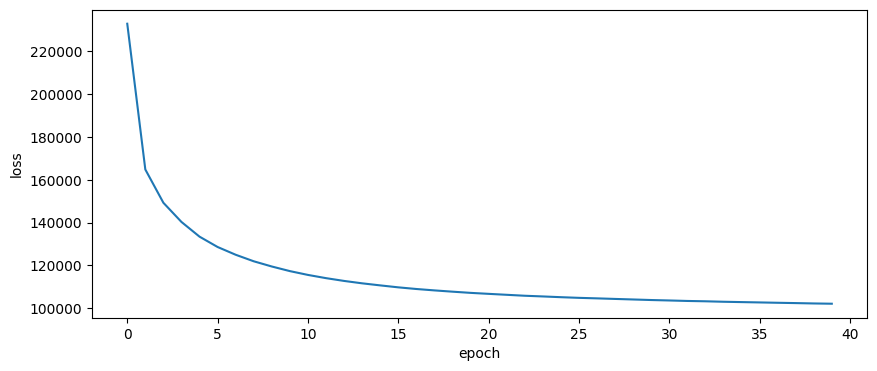

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [15]:
best_model = VariationalAutoEncoder(input_dim=28 * 28, z_dim=32).to(DEVICE)
best_model.load_state_dict(torch.load("./best_model.pth", weights_only=True, map_location=DEVICE))

<All keys matched successfully>

In [17]:
best_model.eval()

encodded = []
generated_imgs = []

with torch.no_grad():
    i = 1
    for img, label in tqdm(test_loader):
        img = img.view(-1, 1 * 28 * 28).to(DEVICE)
        x_reconstructed, mu, sigma, _ = best_model(img)

        x_reconstructed = x_reconstructed.view(-1, 28, 28).cpu()

        for pred, true_img in zip(x_reconstructed, img):
            if i % 100 == 0:
                save_image(pred, f'./generated_images/{i}_predicted.png')
                save_image(true_img.view(1, 28, 28).cpu(), f'./generated_images/{i}_original.png')

            i += 1

100%|██████████| 1000/1000 [00:01<00:00, 636.49it/s]


In [22]:
latent_vectors = []
labels = []

with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images = images.view(-1, 1 * 28 * 28).to(DEVICE)  # Flatten the images
        x_reconstructed, mu, sigma, z = model(images)                         # Get latent vectors
        latent_vectors.extend(mu.cpu())
        labels.extend(targets)

100%|██████████| 1000/1000 [00:01<00:00, 670.20it/s]


In [23]:
latent_2d = TSNE(n_components=2).fit_transform(np.array(latent_vectors))

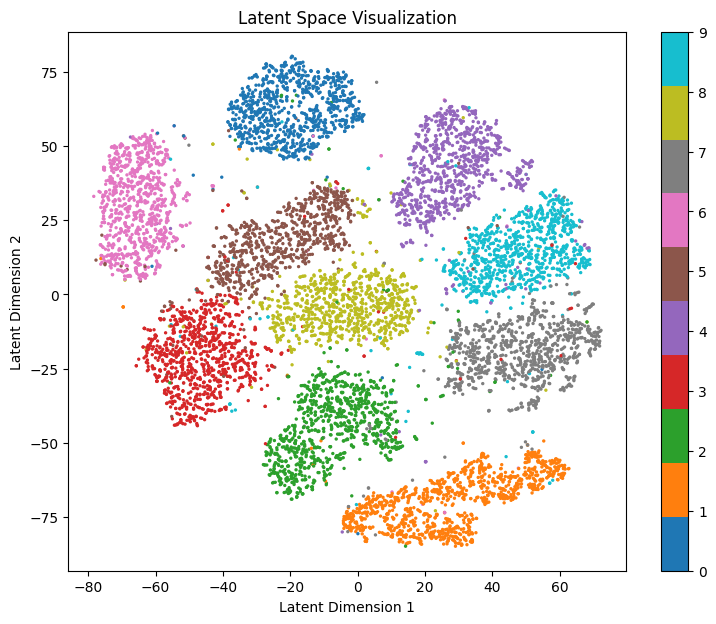

In [24]:
plt.figure(figsize=(9, 7))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', s=2)
plt.colorbar()
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()